In [33]:
from supervised.automl import AutoML
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from contextlib import redirect_stdout
import matplotlib.pyplot as plt


## 1. Models tuned

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

### 2.1 Decision Tree

In [35]:
from sklearn import tree

def decision_tree(df):
    X=df[df.columns[:-1]]
    y=df[df.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    return f1_score(y_test, clf.predict(X_test), average='macro')


### 2.2 Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(df):
    X=final_dataset[final_dataset.columns[:-1]]
    y=final_dataset[final_dataset.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    #hyperparameter-tuning
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 100)]

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 20, num = 100)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    rf = RandomForestClassifier()
    rf_cv = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 5, random_state=42, scoring='f1_macro')
    # Fit the random search model
    rf_cv.fit(X_train, y_train)
    return f1_score(y_test, rf_cv.best_estimator_.predict(X_test), average='macro')

### 2.3 kNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
def kNN(df):
    X=df[df.columns[:-1]]
    y=df[df.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    #hyperparameter-tuning
    knn=KNeighborsClassifier()
    #Create grid
    param_grid = {"n_neighbors": np.arange(1, 25)}
    knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro')
    # Fit the random search model
    knn_cv.fit(X_train,y_train)
    return f1_score(y_test, knn_cv.best_estimator_.predict(X_test), average='macro')

### 2.4 GradientBoosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting(df):
    X=df[df.columns[:-1]]
    y=df[df.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #hyperparameter-tuning
    n_estimators = np.arange(1,100)
    learning_rate = np.linspace(start=1e-1, stop=1, num=10)
    max_depth = np.arange(1,50)

    # Create the random grid
    grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate}
    clf = GradientBoostingClassifier()
    clf_cv = RandomizedSearchCV(estimator = clf, param_distributions = grid, cv = 5, random_state=42, scoring='f1_macro')
    
    # Fit the random search model
    clf_cv.fit(X_train, y_train)
    return f1_score(y_test, clf_cv.best_estimator_.predict(X_test), average='macro')


## 2.Creating dataset with different functions and test models

### 1.2 Function definitions

In [39]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

In [40]:
a=1.5
b=3
def function_log_exp(x,y):
    return (np.exp(a*x))/((1/a)*np.log(y+1))
def function_log_power(x,y):
    return (np.power(x,b))/(np.log(y+1))
def function_log(x,y):
    return x/(np.log(y+1))

In [41]:
def compute_final_dataset(df, function):
    #compute value
    df['value'] = function(df['F1'], df['time'])

    df = df.drop(columns=['F1', 'time', 'consumption','TDP', 'country'])
    #keep most green entry for each dataset
    final_dataset = df.sort_values('value').drop_duplicates(df.columns[:-2],keep='last')
    final_dataset = df_column_switch(final_dataset, 'algo', 'value')
    final_dataset = final_dataset.drop(columns = ['value'])
    return final_dataset

In [42]:
def run_autoML(df):
    X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=0.25)
    automl = AutoML(eval_metric='f1', explain_level=1, top_models_to_improve=4, random_state=2, optuna_verbose=False)
    automl.fit(X_train, y_train)

### 1.2 Selecting best function for evaluating "greenness"

STEP 0 ------------------------------------------------------------------------ 


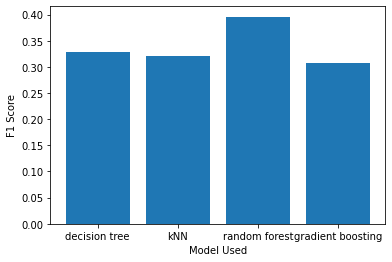

Max F1-score: 0.3957882578318684
STEP 1 ------------------------------------------------------------------------ 


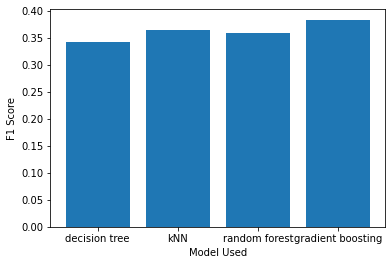

Max F1-score: 0.3841560931916793
STEP 2 ------------------------------------------------------------------------ 


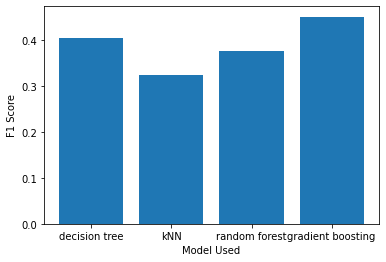

Max F1-score: 0.4507977382655495
FINAL


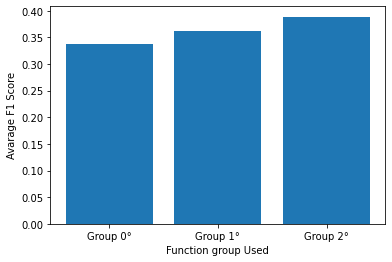

In [43]:
dataset = pd.read_csv('ml_dataset.csv')
dataset_cleaned  = dataset[dataset.algo != 'Ensemble']
dataset_cleaned = dataset_cleaned.drop(columns=['did'])
dataset_cleaned['consumption']=dataset_cleaned['time']*dataset_cleaned['TDP']

list_functions=[function_log_exp, function_log_power, function_log]
list_models=[{"name":"decision tree", "clf":decision_tree}, {"name":"kNN", "clf":kNN}, {"name":"random forest", "clf":random_forest},{"name":"gradient boosting",  "clf":gradient_boosting}]
names=[x['name'] for x in list_models]
avarage_f1=[]
# with open('out.txt', 'w') as f:
#     with redirect_stdout(f):
for i,function in enumerate(list_functions):
    # run_autoML(final_dataset)
    f1_scores=[]
    print(f'STEP {i} ------------------------------------------------------------------------ ')
    dataset_cleaned_copy=dataset_cleaned.copy()
    final_dataset=compute_final_dataset(dataset_cleaned_copy, function)
    
    #drop na
    final_dataset=final_dataset.dropna()
    #min-max normalization
    #final_dataset[features]=(final_dataset[features]-final_dataset[features].min())/(final_dataset[features].max()-final_dataset[features].min())
    for model in list_models:
        f1_scores.append(model['clf'](final_dataset))
    plt.ylabel("F1 Score")
    plt.xlabel("Model Used")
    plt.bar(names, f1_scores)
    plt.show()
    print(f'Max F1-score: {np.max(np.array(f1_scores))}')
    avarage_f1.append(np.mean(np.array(f1_scores)))
    
print(f'FINAL')
plt.ylabel("Avarage F1 Score")
plt.xlabel("Function group Used")
names=[f'Group {i}°' for i in range(len(list_functions))]
plt.bar(names, avarage_f1)
plt.show()

## 3. Compute features for new dataset

In [505]:
def encode_y(y):
    le = LabelEncoder()
    le.fit(y)
    y_enc = le.transform(y)
    return y_enc


def compute_max_corr(df):
    y = encode_y(df[df.columns[-1]])
    y = pd.Series(y)
    corr = df[df.columns[:-1]].corrwith(y)
    return np.max(np.absolute(corr))

In [508]:
def compute_features(df):
    label=df.columns[-1]
    features=df.columns[:-1]
    computed_features=[]

    MajorityClassSize=df.groupby(by=label).size().max()
    computed_features.append(MajorityClassSize)

    MaxNominalAttDistinctValues=df[features].select_dtypes(exclude=[np.number]).nunique().values.max()#must check this
    computed_features.append(MaxNominalAttDistinctValues)

    MinorityClassSize=df.groupby(by=label).size().min()
    computed_features.append(MinorityClassSize)

    NumberOfClasses=df[label].unique().shape[0]
    computed_features.append(NumberOfClasses)

    NumberOfFeatures=df.shape[1]-1
    computed_features.append(NumberOfFeatures)

    NumberOfInstances=df.shape[0]
    computed_features.append(NumberOfInstances)

    NumberOfInstancesWithMissingValues=df.isnull().any(axis=1).sum()
    computed_features.append(NumberOfInstancesWithMissingValues)

    NumberOfMissingValues=df.isnull().all(axis=1).sum()
    computed_features.append(NumberOfMissingValues)

    NumberOfNumericFeatures=df[features].select_dtypes([np.number]).shape[1]
    computed_features.append(NumberOfNumericFeatures)

    NumberOfSymbolicFeatures=df[features].select_dtypes(exclude=[np.number]).shape[1]#must check this
    computed_features.append(NumberOfSymbolicFeatures)

    max_corr=compute_max_corr(df)
    computed_features.append(max_corr)

    return np.array(computed_features)